In [1]:
## InSe Simulation
import abtem
import ase.io
import matplotlib.pyplot as plt
import numpy as np
import py4DSTEM
import scipy
from ase.io import read
from ase.build import surface
from abtem.atoms import pretty_print_transform

# Custom functions used in this script
from FunctionPackageOM.Plot_Style import Plot_Style_OM_activate

# Load custom plot style
Plot_Style_OM_activate(white_bkg_for_visualization=True)


# Uncomment if running in Jupyter
%matplotlib ipympl

cupyx.jit.rawkernel is experimental. The interface can change in the future.


## Settings for GPU vs CPU

In [2]:
# data stored in the config
abtem.config.config

{'device': 'cpu',
 'fft': 'fftw',
 'precision': 'float32',
 'diagnostics': {'progress_bar': True, 'task_progress': False},
 'dask': {'lazy': True, 'chunk-size': '128 MB', 'chunk-size-gpu': '512 MB'},
 'cupy': {'fft-cache-size': '0 MB'},
 'mkl': {'threads': 2},
 'fftw': {'threads': 1,
  'planning_effort': 'FFTW_MEASURE',
  'planning_timelimit': 60,
  'allow_fallback': True},
 'warnings': {'dask-blockwise-performance': False, 'overspecified-grid': True},
 'antialias': {'cutoff': 0.6666666, 'taper': 0.01},
 'visualize': {'real_space_units': 'Angstrom',
  'reciprocal_space_units': 'Angstrom',
  'cmap': 'viridis',
  'phase_cmap': 'hsluv',
  'continuous_update': False,
  'autoscale': False,
  'use_tex': True}}

In [3]:
## set to gpu or cpu
# abtem.config.set({"device": "cpu"})
abtem.config.set({"device": "gpu"})

Text(0.5, 0.98, 'InSe_on_sapphire full structure')

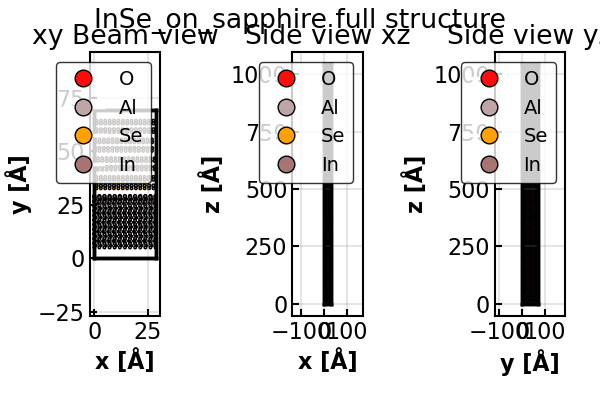

In [4]:
## load simulation file

InSe_on_sapphire = ase.io.read('/masc_shared/ag_volz/Oliver_Maßmeyer/CIF_Files/ModifiedCIFs/InSeOnSapphireSimulationCell100nm.xyz')
#check cell
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(InSe_on_sapphire, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(InSe_on_sapphire, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(InSe_on_sapphire, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)
fig.tight_layout()
fig.suptitle('InSe_on_sapphire full structure')

In [224]:
## calculate MSDs (Schowalter Paper) // take aveage between 200 and 400

#GaP (almost the same as calculated GaS!)
GainGaP = (4.895e-5+9.373e-5)/2 # in nm²
PinGaP = (4.547e-5+8.217e-5)/2 # in nm²

##InAs 
IninInAs = (8.742e-5+17.226e-5)/2 # in nm²
AsinInAs = (7.520e-5+14.65e-5)/2 # in nm²

GainGaP, PinGaP, IninInAs, AsinInAs

(7.134e-05, 6.382e-05, 0.00012984, 0.00011085000000000001)

In [225]:
## caluclate Frozen Phonons

# displacements_nm = {'Ga': 7.113736674861319e-05, 'S':6.352344019765251e-05, 'Al': 2.96e-05, 'O': 3.312e-05} #  MSDs - GaS simulation (nm²)

displacements_nm = {'In': 1.2984e-4, 'Se':1.1085e-04, 'Al': 2.96e-05, 'O': 3.312e-05} #  MSDs InSe Simulation (values taken from InAs schowalter )

displacements_Ang = {key:displacements_nm[key]**0.5*10 for key in displacements_nm.keys()} # conversion nm² to Ang

print(displacements_Ang) # displacments in Ang

frozen_phonons = abtem.FrozenPhonons(InSe_on_sapphire, num_configs=10, sigmas=displacements_Ang, seed=1993)
# frozen_phonons = abtem.FrozenPhonons(InSe_on_sapphire, num_configs=0, sigmas=displacements_Ang, seed=1993)

# frozen_phonons = GaS_on_sapphire


{'In': 0.11394735626595291, 'Se': 0.10528532661297109, 'Al': 0.054405882034941774, 'O': 0.05754997827975263}


Text(0.5, 0.98, 'Current Phonon Configuration')

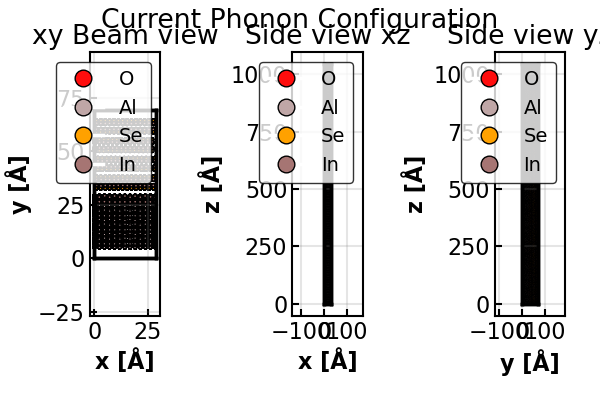

In [226]:
atoms_configuration = next(iter(frozen_phonons))
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(atoms_configuration, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(atoms_configuration, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(atoms_configuration, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)
fig.tight_layout()
fig.suptitle('Current Phonon Configuration')

In [227]:
InSe_on_sapphire.cell

Cell([28.707759570000004, 69.38839173478067, 1043.7578306439088])

In [228]:
## determine slice thickness (1 unit cell)

zUnitCell = 17.55041/2 ## in Ang

## number of slices

numSlices = InSe_on_sapphire.cell[2][2]/zUnitCell
print('numSlices: ', numSlices)

## recalculate slice thickness

sliceThickness = InSe_on_sapphire.cell[2][2]/119
print('sliceThickness: ', sliceThickness)

numSlices:  118.94398257863023
sliceThickness:  8.77107420709167


In [229]:
900/sliceThickness

102.61000862041774

Length of the Potential 119
[########################################] | 100% Completed | 10.79 s


ImageGUI(children=(VBox(children=(SelectionSlider(continuous_update=False, description='Frozen phonons', optio…

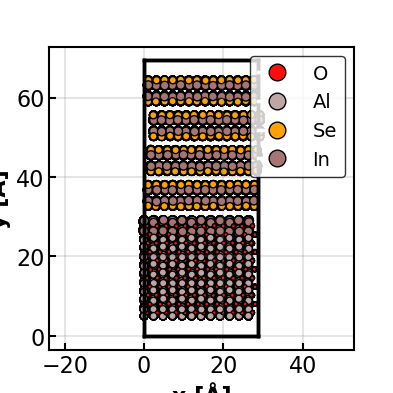

In [230]:

#parameters:
energy = 200e3 # volts
semiangle_cutoff = 21 # mrad
defocus = 0 # ang

#Create the Potentials by independent atom model (IAM)
potential = abtem.Potential(
    frozen_phonons,
    sampling=0.03, # lower sampling to match 4D data // determines the max scattering angle later?
    # sampling=0.1,
    # parametrization="lobato",
    exit_planes = [103,118],
    parametrization="kirkland",
    slice_thickness=8.77107420709167, # from construction
    projection="infinite",
)

print("Length of the Potential",len(potential))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

atoms_configuration = next(iter(frozen_phonons))

abtem.show_atoms(atoms_configuration, legend=True)

## caluclate projected potential
potentialImage = potential.project()

potentialImage.show(interact=True,cbar=True)

# visualize the first slice
# visualization = potential[0].show(ax=ax2,cbar=True);

# # #visualize slices of the potential
# visualization = potential[0:3].show(
#     project=False,
#     explode=True,
#     figsize=(10, 2),
#     common_color_scale=True,
#     cbar=True,
#     vmin=0,
#     vmax=100,
# )

# plt.show()

defocus = 0 Å
FWHM = 0.5999531745910645 Å
[########################################] | 100% Completed | 100.85 ms
[########################################] | 100% Completed | 100.78 ms


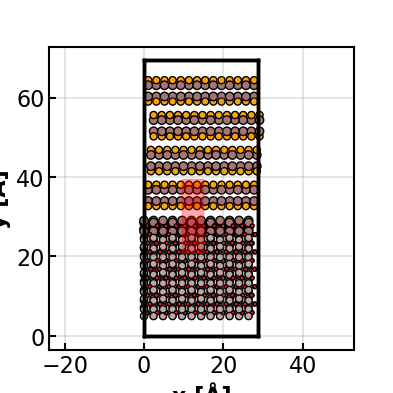

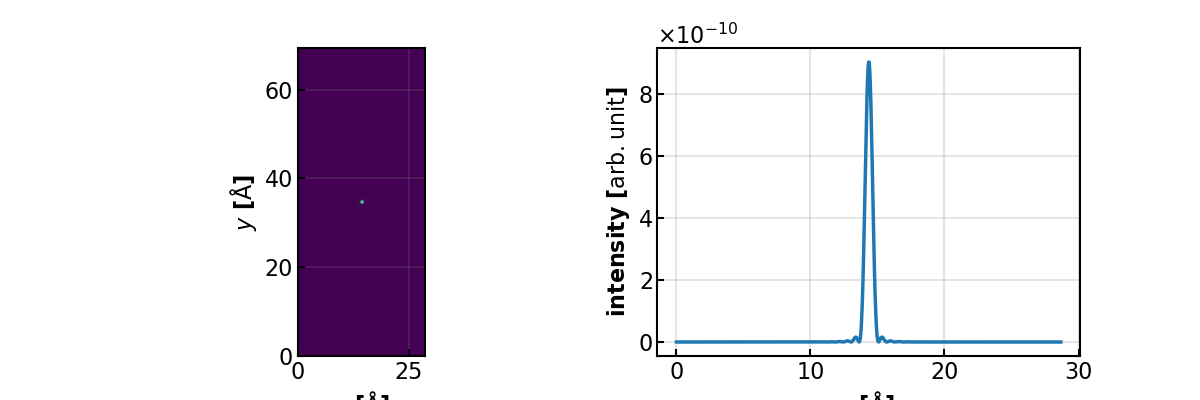

In [231]:
#create STEM Probe - 200 kV - 21 mrad Aperture, -50 um spheriacal abberation, defocus of 50 A
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    # C10=defocus,
    C10=0, # defocus
    # Cs=-50e-6 * 1e10,
    C50=0.5e6, #5th order spherical aberration
    C30=-2.2e3, #3th order spherical aberration
)

probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

#plot the probe profile
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);


#apply detector settings for sampling
# num_detector_pixels = 64 # px
maximum_scattering_angle_mrad = np.max(probe.cutoff_angles) # mrad

# resample = 2*maximum_scattering_angle_mrad/num_detector_pixels

#detector
pixelated_detector = abtem.PixelatedDetector(
    # max_angle=maximum_scattering_angle_mrad*0.975,
    max_angle=maximum_scattering_angle_mrad,
    # resample=(resample,resample)
)

flexibleAnnularDetector = abtem.FlexibleAnnularDetector()



#setup grid scan
scan_step_size = 0.2 # ang
# scan_step_size = 0.4 # ang

grid_scan = abtem.GridScan(
    sampling=scan_step_size,  
    # start=[0.25, 0.1],
    # end=[0.75, 0.98],

    start=[0.33, 0.3],
    end=[0.52, 0.57],

    # start=[0.4, 0.4],
    # end=[0.6, 0.6],
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(InSe_on_sapphire)
grid_scan.add_to_plot(ax)

plt.show()

In [14]:
#compute the measurement
print(
    f"Maximum simulated scattering angle = {min(probe.cutoff_angles):.1f} mrad"
)

# measurements = probe.scan(potential, scan=grid_scan, detectors=pixelated_detector)
measurements = probe.scan(potential, scan=grid_scan, detectors=flexibleAnnularDetector)
measurements.compute()
measurements.to_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/InSe_on_Sapphire_cross_section/ABTEM/InSe_on_sapphire_100nm_Phonons_SmallerStepSize_thickness_highDensit23y.zarr");

Maximum simulated scattering angle = 277.8 mrad
[########################################] | 100% Completed | 2hr 36m
[########################################] | 100% Completed | 102.14 ms


In [13]:
## Save the Calculations
# measurements.to_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_Phonons.zarr");
# measurements.to_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_NoPhonons.zarr");

[########################################] | 100% Completed | 2.97 ss


## Visualize the simulation results

In [18]:
measurements.shape

(2, 36, 153, 194, 468)

In [4]:
## load the simulations
# measurementNoPhonons = abtem.from_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/GaS_on_Sapphire_cross_section/ABTEM/GaS_on_sapphire_200nm_NoPhonons.zarr")
# measurement10Phonons = abtem.from_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/InSe_on_Sapphire_cross_section/ABTEM/InSe_on_sapphire_100nm_Phonons_SmallerStepSize_thickness.zarr")
measurement10Phonons = abtem.from_zarr("/masc_shared/ag_volz/Oliver_Maßmeyer/TEM_Simulations/InSe_on_Sapphire_cross_section/ABTEM/InSe_on_sapphire_100nm_Phonons_SmallerStepSize_thickness_highDensity.zarr")


In [5]:
measurement10Phonons.shape

(2, 28, 94, 277, 1)

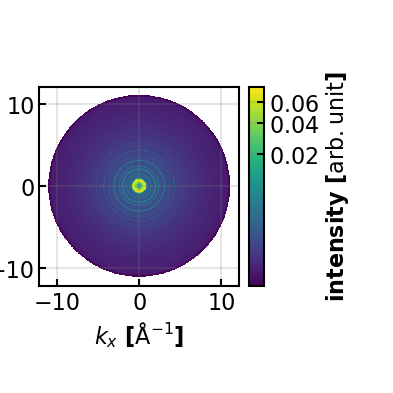

In [6]:
measurement10Phonons[0][0,0].show(power=0.3,cmap='viridis',cbar=True,explode=True)

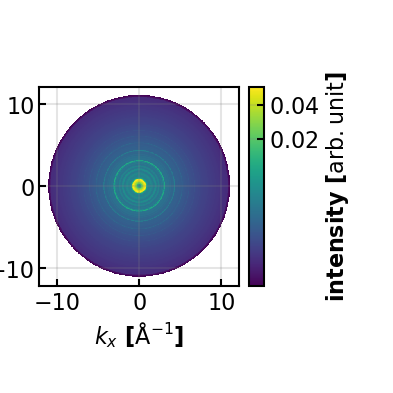

In [8]:
## for full simulation ~ 90 nm
measurementsMean = measurement10Phonons[0].mean((0,1))
measurementsMean.show(power=0.3,cmap='viridis',cbar=True,explode=True)

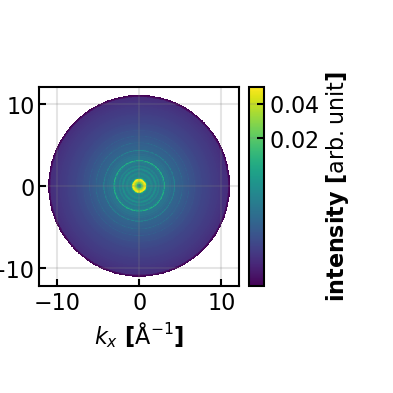

In [10]:
## for full simulation ~ 100 nm
measurementsMean = measurement10Phonons[1].mean((0,1))
measurementsMean.show(power=0.3,cmap='viridis',cbar=True,explode=True)

In [11]:
## visualize the dark field images
# HAADF preview

stacked = abtem.stack(
    [
        # measurement10Phonons[0].integrate_radial(0, 30),
        # measurement10Phonons[0].integrate_radial(75, 278),
        measurement10Phonons[0].integrate_radial(50, 84),
        measurement10Phonons[1].integrate_radial(50, 84),
    ],
    ("ADF - 90nm", "ADF - 100 nm"),
)

stacked.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True);
# plt.show()


[########################################] | 100% Completed | 102.48 ms


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

In [111]:
## interpolate to sampling of image

stackInterpolated = stacked.interpolate(0.3)
stackInterpolated.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True);

[########################################] | 100% Completed | 100.96 ms


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

In [13]:
## apply probe size

stackInterpolatedGaussian = stackInterpolated.gaussian_filter(0.35)
stackInterpolatedGaussian.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True);


[########################################] | 100% Completed | 102.03 ms


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

In [14]:
## add possion noise 

stackInterpolatedGaussianNoise = stackInterpolatedGaussian.poisson_noise(dose_per_area=1e4)
stackInterpolatedGaussianNoise.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True);

[########################################] | 100% Completed | 102.03 ms


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

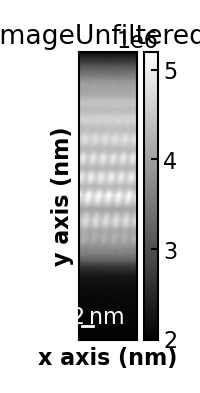

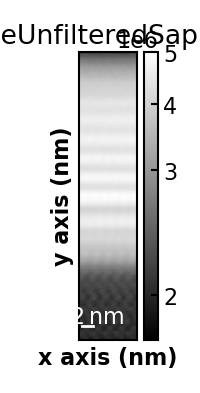

In [169]:
## load the measurement data

import hyperspy.api as hs
import os
fp = '/masc_shared/ag_volz/Oliver_Maßmeyer/InSe/InSe_Paper'
fsf = 'StackedImages' # define save folder

imageStackedOnInPositions = hs.load(os.path.join(fp,fsf ,'MeanImageUnfiltered.hspy'))
imageStackedOnInPositions.plot()

imageStackedOnAlPositions = hs.load(os.path.join(fp,fsf ,'MeanImageUnfilteredSapphire.hspy'))
imageStackedOnAlPositions.plot(norm='power', gamma=0.5)

## plot simulation



In [232]:
## image section with correct annular range

HAADFSTEMSimulationArray = measurement10Phonons[0].integrate_radial(74, 276),

HAADFSTEMSimulation = abtem.stack(HAADFSTEMSimulationArray)
HAADFSTEMSimulation = HAADFSTEMSimulation.interpolate([0.28,0.275])
HAADFSTEMSimulation = HAADFSTEMSimulation.gaussian_filter(0.2)
HAADFSTEMSimulation = HAADFSTEMSimulation.poisson_noise(dose_per_area=1e5)

# HAADFSTEMSimulation

HAADFSTEMSimulation.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True) #, #vmin = 0 ,vmax = 0.35);

[########################################] | 100% Completed | 101.18 ms


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

In [212]:
# compare the sampling
print('sampling Simulation:', HAADFSTEMSimulation.sampling)
print('sampling Measurement:', imageStackedOnInPositions.axes_manager[0].scale)

sampling Simulation: (0.27272371591500005, 0.2715197937447939)
sampling Measurement: 0.027366062626242638


In [213]:
#cut at y = 136 and combine the experimental images
averageImageCombined = np.concatenate((imageStackedOnInPositions.data[:136], imageStackedOnAlPositions.data[136:]), axis=0)
averageImageCombined.shape

(200, 40)

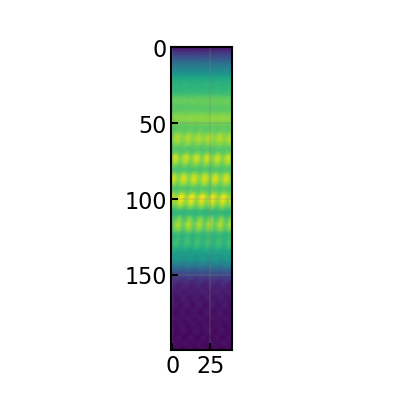

In [214]:
## match the images
plt.close('all')
# plt.imshow(HAADFSTEMSimulation.array[0])
# plt.imshow(imageStackedOnInPositions.data[:136])
# plt.imshow(imageStackedOnAlPositions.data[136:])
plt.imshow(averageImageCombined/np.max(averageImageCombined))
plt.show()



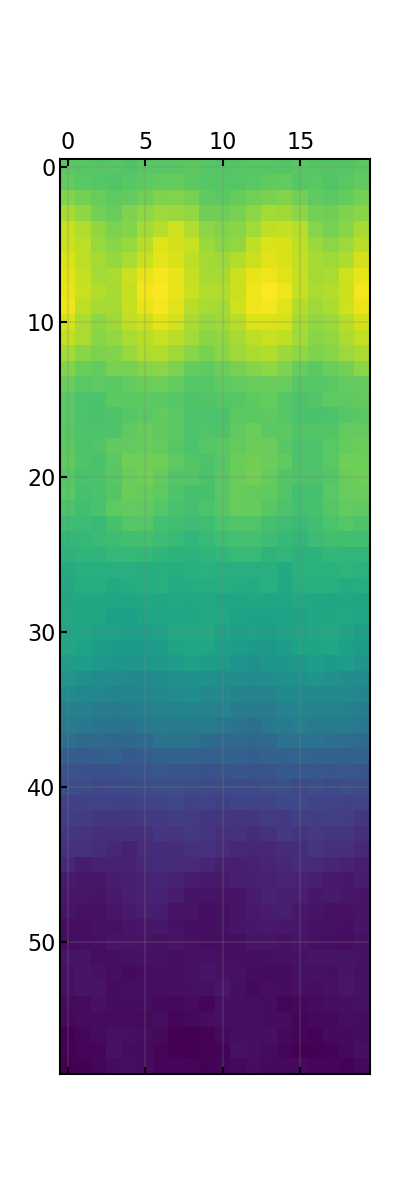

In [215]:
## crop section of averaged image

averageImageCombinedCropped = averageImageCombined/np.max(averageImageCombined)
averageImageCombinedCropped = averageImageCombinedCropped[109:168,12:32]
# averageImageCombinedCropped = averageImageCombinedCropped[8:22,100:168].shape

plt.matshow(averageImageCombinedCropped)

In [216]:
averageImageCombinedCropped.shape

(59, 20)

In [217]:
HAADFSTEMSimulationNormalized.shape

(20, 69)

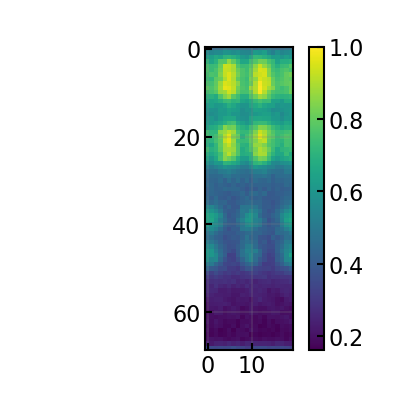

In [218]:
## normalize the simulation
HAADFSTEMSimulationNormalized = HAADFSTEMSimulation.array[0]/np.max(HAADFSTEMSimulation.array[0])

plt.close('all')
plt.imshow(np.flip(HAADFSTEMSimulationNormalized.T))
plt.colorbar()
plt.show()

In [219]:
## match the size to the expermiment
HAADFSTEMSimulationNormalizedCropped = np.flip(HAADFSTEMSimulationNormalized)
HAADFSTEMSimulationNormalizedCropped = HAADFSTEMSimulationNormalizedCropped.T
HAADFSTEMSimulationNormalizedCropped = HAADFSTEMSimulationNormalizedCropped[:59,:]
HAADFSTEMSimulationNormalizedCropped.shape

(59, 20)

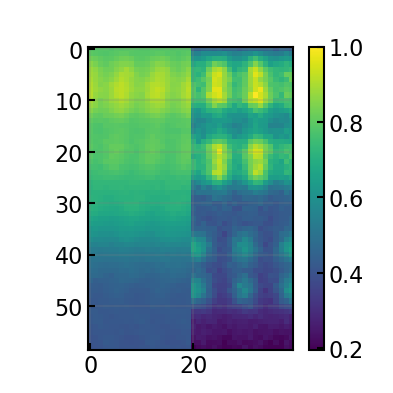

In [220]:
## combine simulation and measurement

finalCombinedImage = np.concatenate((averageImageCombinedCropped, HAADFSTEMSimulationNormalizedCropped), axis=1) 
plt.close('all')
plt.imshow(finalCombinedImage)
plt.colorbar()
plt.show()

In [ ]:
HAADFSTEMSimulationNormalized.

In [ ]:
## make comparision to experimental STEM image

## load stacked images

## make overview of folder
fp = '/masc_shared/ag_volz/Oliver_Maßmeyer/InSe/InSe_Paper'
files = User_Functions.ListFilesFormatedSortedByTime(fp)

# store as hspy
fsf = 'StackedImages' # define save folder
imageMean.save(os.path.join(fp,fsf ,'MeanImageUnfiltered.hspy'))

imageMean = hs.l

[########################################] | 100% Completed | 3.13 sms


KeyboardInterrupt: 

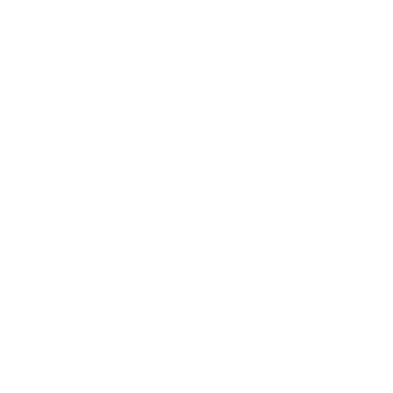

In [32]:
measurement10Phonons.show(power=0.3,cmap='viridis',cbar=True,explode=True)

In [33]:
measurementsMean = measurement10Phonons.mean((1,2))

RuntimeError: base axes cannot be reduced

In [31]:
measurements = abtem.stack(
    [measurementNoPhonons, measurement10Phonons], ("NoPhonons", "10PhononConfigurations")
)

NameError: name 'measurementNoPhonons' is not defined

In [11]:
measurementsMean = measurements.mean((1,2))

[########################################] | 100% Completed | 26.29 s


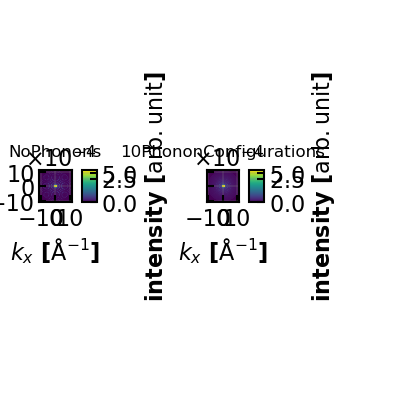

In [12]:
measurementsMean.show(power=0.3,cmap='viridis',cbar=True,explode=True)

[########################################] | 100% Completed | 7.28 sms


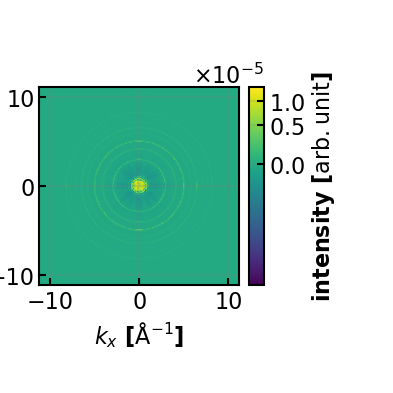

In [13]:
deviationMean = measurementsMean[0]-measurementsMean[1]
deviationMean.show(power=0.3,cmap='viridis',cbar=True,explode=True)

[########################################] | 100% Completed | 8.07 sms


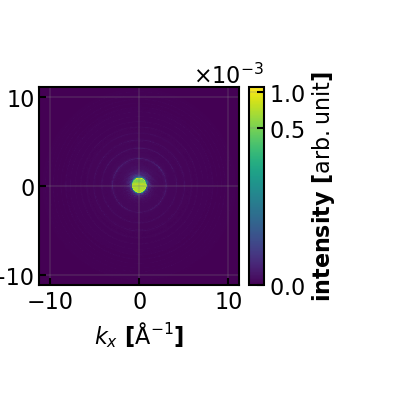

In [14]:
# PACBED single phonon configuration
measurements.mean((0,1)).show(power=0.3,cmap='viridis',cbar=True);

In [19]:
measurements.shape

(2, 28, 60, 494, 665)

In [18]:
measurements[1, 1].shape

(60, 494, 665)

In [ ]:
#visualize diffration pattern

cropped_diffraction_pattern = measurements[1, 1].crop(max_angle=180)

abtem.stack(
    [
        cropped_diffraction_pattern,
        cropped_diffraction_pattern.block_direct(),
    ],
    ("base", "block direct"),
).show(power=0.2,explode=True, cbar=True, figsize=(12, 6));

In [20]:
# HAADF preview

stacked = abtem.stack(
    [
        measurements.integrate_radial(0, 30),
        measurements.integrate_radial(75, 278),
        
    ],
    ("BF", "ADF"),
)

stacked.show(explode=True, cbar=True, figsize=(10, 10), cmap='gray', interact=True);
# plt.show()

[########################################] | 100% Completed | 17.30 s


ImageGUI(children=(VBox(children=(HBox(children=(Button(description='Reset sliders', style=ButtonStyle()), Tog…

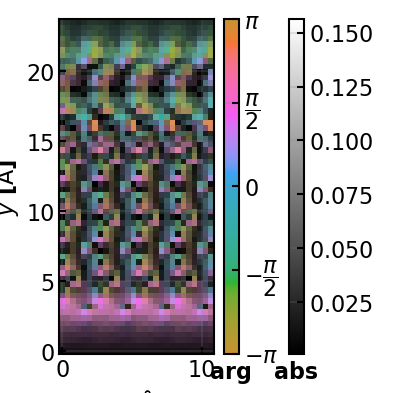

In [24]:
#check sampling with COM
center_of_mass = measurements.center_of_mass(units="1/Å")

# interpolated_center_of_mass = center_of_mass.interpolate(0.05)
# interpolated_center_of_mass = center_of_mass.interpolate(0.05).tile((10, 1))

center_of_mass.show(cbar=True);

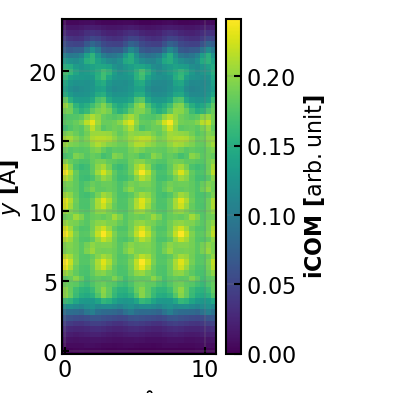

In [25]:
#
integrated_gradient = center_of_mass.integrate_gradient()

# interpolated_integrated_gradient = integrated_gradient.interpolate(0.05)

integrated_gradient.show(cbar=True);
plt.show()

In [ ]:
## remove vacuum from cell

# Get atomic positions
positions = GaS_on_sapphire.get_positions()

# Find minimum and maximum coordinates along each axis
min_pos = positions.min(axis=0)
max_pos = positions.max(axis=0)

# Compute the new cell dimensions (tight bounding box)
new_cell = max_pos - min_pos

# Shift atoms so the structure starts at origin
GaS_on_sapphire.translate(-min_pos)

# Update the cell
GaS_on_sapphire.set_cell(new_cell)
GaS_on_sapphire.set_pbc([True, True, True])  # Set periodic boundary conditions if needed

# plot 
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(6, 4))
abtem.show_atoms(GaS_on_sapphire, ax=ax1, title="xy Beam view", show_periodic=True, scale=0.5, legend=True)
abtem.show_atoms(GaS_on_sapphire, ax=ax2, plane="xz", title="Side view xz", show_periodic=True, scale=0.5,
                 legend=True)
abtem.show_atoms(GaS_on_sapphire, ax=ax3, plane="yz", title="Side view yz", show_periodic=True, scale=0.5,
                 legend=True)
fig.tight_layout()
fig.suptitle('GaS_on_sapphire full structure')

In [9]:
## Timing box GPU
abtem.config.set({"device": "gpu"})
lengths = GaS_on_sapphire.cell.lengths()
num_slices = 200

%timeit abtem.Potential(GaS_on_sapphire, sampling=0.15, parametrization="kirkland", slice_thickness=lengths[2]/num_slices, projection="infinite")



519 μs ± 11.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [10]:
## Timing box GPU
abtem.config.set({"device": "cpu"})
lengths = GaS_on_sapphire.cell.lengths()
num_slices = 200

%timeit abtem.Potential(GaS_on_sapphire, sampling=0.15, parametrization="kirkland", slice_thickness=lengths[2]/num_slices, projection="infinite")



398 μs ± 821 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
